Computing free energy differences with two Boltzmann generators
------
Here we construct two Boltzmann generators (x <--> z) and (y <-->z) that map two different parts of configuration space to the same latent space. We then sample from latent space and compute free energy differences between the two sets of configurations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf
import pyemma
from pyemma.util.statistics import confidence_interval

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

/Users/noe/anaconda/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.3.
  .format(latest=latest, current=current), category=UserWarning)


In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
def getx(x):
    return x[:, 0]

Double well
---

In [7]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

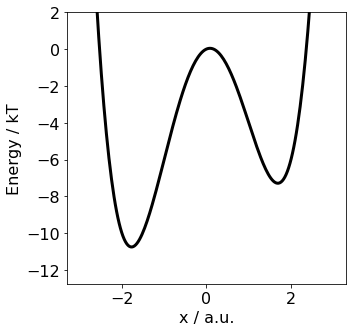

In [8]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();
#plt.savefig(paper_dir + 'figs/doublewell_potential.pdf', bbox_inches='tight')

In [9]:
print(params)

{'a4': 1.0, 'a1': 1.0, 'k': 1.0, 'a2': 6.0, 'dim': 2}


In [10]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [11]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

Text(0.5,0,'Probability')

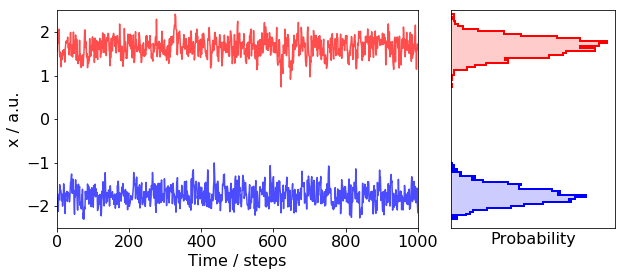

In [12]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('x / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')
#plt.savefig(paper_dir + 'figs/doublewell_prior_trajs.pdf', bbox_inches='tight')

In [13]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [14]:
# prepare transition state
x_ts = np.vstack([np.zeros(1000), (1.0/double_well.params['k']) * np.random.randn(1000)]).T

In [15]:
def plot_potential(labels=True, cbar=True):
    # 2D potential
    xgrid = np.linspace(-3, 3, 100)
    ygrid = np.linspace(-6, 6, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten()]).T
    E = double_well.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=(5, 4))
    plt.contourf(Xgrid, Ygrid, E, 50, cmap='jet', vmax=4)
    if cbar:
        cbar = plt.colorbar()
        cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$ / a.u.')
        plt.ylabel('$x_2$ / a.u.')
    else:
        plt.xticks([])
        plt.yticks([])        

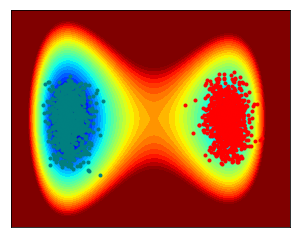

In [16]:
plot_potential(labels=False, cbar=False)
plt.plot(traj_left[:, 0], traj_left[:, 1], color='teal', linewidth=0, marker='.')
plt.plot(traj_right[:, 0], traj_right[:, 1], color='red', linewidth=0, marker='.')
#plt.savefig(paper_dir + 'figs/double_well/xdist_2BGs.pdf', bbox_inches='tight')

Training
-------

In [17]:
batchsize_ML = 128
batchsize_KL = 1000

In [18]:
def train_flexible(network, epochsE, x, xval=None, wML=1.0, wKL=1.0, wW2=0.0, wRC=0.0, temperature=1.0, explore=1.0, return_test_energies=False):
    nterms = 0
    if wML > 0:
        nterms +=1
    if wKL > 0:
        nterms +=1
    if wW2 > 0:
        nterms +=1
    if nterms == 1 and wKL > 0:
        _, loss_train, loss_val = network.train_KL(lr=0.001, epochs=epochsE, batch_size=batchsize_KL, explore=explore, verbose=0)
        return loss_train, loss_val
    else:
        returns = network.train_flexible(x, xval=xval, lr=0.001, epochs=epochsE, 
                                         batch_size=batchsize_KL, std=1.0,
                                         weight_ML=wML, weight_KL=wKL, weight_MC=0.0, weight_W2=wW2, weight_RCEnt=wRC, 
                                         rc_func=getx, rc_min=-2.5, rc_max=2.5,
                                         temperature=temperature, explore=explore, 
                                         verbose=0, return_test_energies=return_test_energies)
        return returns[1:]

Temperature dependence, direct estimate
----

In [26]:
from deep_boltzmann.networks.training import MLTrainer, FlexibleTrainer

In [27]:
temperature = np.array([0.5, 1.0, 2.0, 4.0])
temperatures_analysis = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.8, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5, 4.0]

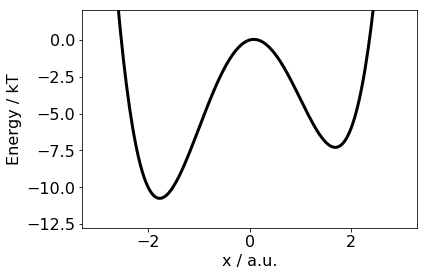

In [28]:
# compute exact free energy difference
xx, xE = double_well.plot_dimer_energy();
dFs_ref = []
Rs = []
for T in temperatures_analysis:
    W = np.exp(-xE / T)
    r = np.sum(W[xx>=0]) / np.sum(W[xx<0])
    Rs.append(r)
    dFs_ref.append(-np.log(r))

In [29]:
def train_and_sample_free_energy(trainer, model, xtrain, temperatures_analysis, 
                                 nsample=100, nepochs_per_iter=10, niter=100, train_batchsize=None):
    bg = trainer.bg
    # Train and sample for multiple temperatures
    F_by_temp = [[] for T in temperatures_analysis]
    Ex_by_temp = [[] for T in temperatures_analysis]
    Jzx_by_temp = [[] for T in temperatures_analysis]
    for i in range(niter):  # training iteration
        print(i, '/', niter)
        if train_batchsize is None:
            trainer.train(xtrain, epochs=nepochs_per_iter)
        else:
            trainer.train(xtrain, epochs=nepochs_per_iter, batch_size=train_batchsize)
        for t, T in enumerate(temperatures_analysis):  # temperature iteration
            samples_z = np.sqrt(T) * np.random.randn(nsample, model.dim)
            samples_x, samples_Jzx = bg.transform_zxJ(samples_z)
            samples_enerx = model.energy(samples_x)
            Ex_by_temp[t].append(samples_enerx)
            Jzx_by_temp[t].append(samples_Jzx)     
    for t, T in enumerate(temperatures_analysis):  # temperature iteration
        F_by_temp[t] = np.concatenate(Ex_by_temp[t]) / T - np.concatenate(Jzx_by_temp[t])
        #Ex_by_temp[t] = np.concatenate(Ex_by_temp[t])
        #Jzx_by_temp[t] = np.concatenate(Jzx_by_temp[t])
    return F_by_temp

In [30]:
def dF_running_mean(dFs, window=100, step=1, dF_cut=50):
    dF_runningmean = []
    for i in range(0, dFs.size-window, step):
        chunk = dFs[i:i+window]
        chunk_reg = chunk[np.logical_and(chunk > -dF_cut, chunk < dF_cut)]
        dF_runningmean.append(chunk_reg.mean())
    return dF_runningmean

In [31]:
bg1 = invnet(double_well.dim, 'RRRR', double_well, nl_layers=2, nl_hidden=100, 
             nl_activation='relu', nl_activation_scale='tanh')
bg2 = invnet(double_well.dim, 'RRRR', double_well, nl_layers=2, nl_hidden=100, 
             nl_activation='relu', nl_activation_scale='tanh')

<RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0
<RRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [32]:
mltrainer1 = MLTrainer(bg1, lr=0.001)
mltrainer2 = MLTrainer(bg2, lr=0.001)

Compiling the graph
Compiling the graph


In [33]:
F1_ML_by_temp = train_and_sample_free_energy(mltrainer1, double_well, traj_left, temperatures_analysis, 
                                             train_batchsize=128, nsample=1000, nepochs_per_iter=10, niter=20)
F2_ML_by_temp = train_and_sample_free_energy(mltrainer2, double_well, traj_right, temperatures_analysis, 
                                             train_batchsize=128, nsample=1000, nepochs_per_iter=10, niter=20)

0 / 20
Epoch 0/10 loss 2.9221 
Epoch 1/10 loss 2.6320 
Epoch 2/10 loss 2.3288 
Epoch 3/10 loss 2.2576 
Epoch 4/10 loss 2.0792 
Epoch 5/10 loss 1.8697 
Epoch 6/10 loss 1.8033 
Epoch 7/10 loss 1.7389 
Epoch 8/10 loss 1.6127 
Epoch 9/10 loss 1.4428 
1 / 20
Epoch 0/10 loss 1.4036 
Epoch 1/10 loss 1.3728 
Epoch 2/10 loss 1.3105 
Epoch 3/10 loss 1.2653 
Epoch 4/10 loss 1.1605 
Epoch 5/10 loss 1.0991 
Epoch 6/10 loss 1.0298 
Epoch 7/10 loss 0.9805 
Epoch 8/10 loss 1.0817 
Epoch 9/10 loss 0.9247 
2 / 20
Epoch 0/10 loss 0.9059 
Epoch 1/10 loss 1.0262 
Epoch 2/10 loss 0.8641 
Epoch 3/10 loss 0.8013 
Epoch 4/10 loss 0.8311 
Epoch 5/10 loss 0.8568 
Epoch 6/10 loss 0.7929 
Epoch 7/10 loss 0.7805 
Epoch 8/10 loss 0.8386 
Epoch 9/10 loss 0.7085 
3 / 20
Epoch 0/10 loss 0.7006 
Epoch 1/10 loss 0.6211 
Epoch 2/10 loss 0.6373 
Epoch 3/10 loss 0.5915 
Epoch 4/10 loss 0.7016 
Epoch 5/10 loss 0.5218 
Epoch 6/10 loss 0.5093 
Epoch 7/10 loss 0.5596 
Epoch 8/10 loss 0.6311 
Epoch 9/10 loss 0.4849 
4 / 20
Epoch

Epoch 4/10 loss -0.3583 
Epoch 5/10 loss -0.4398 
Epoch 6/10 loss -0.4296 
Epoch 7/10 loss -0.5693 
Epoch 8/10 loss -0.4541 
Epoch 9/10 loss -0.4596 
13 / 20
Epoch 0/10 loss -0.4802 
Epoch 1/10 loss -0.4430 
Epoch 2/10 loss -0.3284 
Epoch 3/10 loss -0.4281 
Epoch 4/10 loss -0.5181 
Epoch 5/10 loss -0.3969 
Epoch 6/10 loss -0.4883 
Epoch 7/10 loss -0.5207 
Epoch 8/10 loss -0.4930 
Epoch 9/10 loss -0.5047 
14 / 20
Epoch 0/10 loss -0.5541 
Epoch 1/10 loss -0.3684 
Epoch 2/10 loss -0.4482 
Epoch 3/10 loss -0.5498 
Epoch 4/10 loss -0.6051 
Epoch 5/10 loss -0.4469 
Epoch 6/10 loss -0.4145 
Epoch 7/10 loss -0.4469 
Epoch 8/10 loss -0.5156 
Epoch 9/10 loss -0.5719 
15 / 20
Epoch 0/10 loss -0.5653 
Epoch 1/10 loss -0.4511 
Epoch 2/10 loss -0.5990 
Epoch 3/10 loss -0.2866 
Epoch 4/10 loss -0.3730 
Epoch 5/10 loss -0.4856 
Epoch 6/10 loss -0.4262 
Epoch 7/10 loss -0.4910 
Epoch 8/10 loss -0.4861 
Epoch 9/10 loss -0.5908 
16 / 20
Epoch 0/10 loss -0.4215 
Epoch 1/10 loss -0.5689 
Epoch 2/10 loss -0

In [34]:
flextrainer1 = FlexibleTrainer(bg1, lr=0.0001, batch_size=batchsize_KL, high_energy=10000, w_ML=1.0, w_KL=1.0, 
                               temperature=temperature, weigh_ML=False)
flextrainer2 = FlexibleTrainer(bg2, lr=0.0001, batch_size=batchsize_KL, high_energy=10000, w_ML=1.0, w_KL=1.0, 
                               temperature=temperature, weigh_ML=False)

In [35]:
F1_KL_by_temp = train_and_sample_free_energy(flextrainer1, double_well, traj_left, temperatures_analysis, 
                                             nsample=1000, nepochs_per_iter=10, niter=50)
F2_KL_by_temp = train_and_sample_free_energy(flextrainer2, double_well, traj_right, temperatures_analysis, 
                                             nsample=1000, nepochs_per_iter=10, niter=50)

0 / 50
Epoch 0/10 loss -7.6925 index_layer_15_loss -0.4835 index_layer_18_loss -7.2090 
Epoch 1/10 loss -7.8031 index_layer_15_loss -0.4961 index_layer_18_loss -7.3070 
Epoch 2/10 loss -7.8478 index_layer_15_loss -0.5091 index_layer_18_loss -7.3387 
Epoch 3/10 loss -7.7220 index_layer_15_loss -0.4603 index_layer_18_loss -7.2617 
Epoch 4/10 loss -7.7624 index_layer_15_loss -0.5066 index_layer_18_loss -7.2558 
Epoch 5/10 loss -7.7989 index_layer_15_loss -0.4921 index_layer_18_loss -7.3068 
Epoch 6/10 loss -7.8828 index_layer_15_loss -0.5084 index_layer_18_loss -7.3745 
Epoch 7/10 loss -7.7620 index_layer_15_loss -0.4726 index_layer_18_loss -7.2894 
Epoch 8/10 loss -7.8879 index_layer_15_loss -0.5088 index_layer_18_loss -7.3792 
Epoch 9/10 loss -7.6768 index_layer_15_loss -0.4484 index_layer_18_loss -7.2283 
1 / 50
Epoch 0/10 loss -7.6967 index_layer_15_loss -0.4720 index_layer_18_loss -7.2248 
Epoch 1/10 loss -7.8984 index_layer_15_loss -0.4659 index_layer_18_loss -7.4325 
Epoch 2/10 los

Epoch 1/10 loss -7.9470 index_layer_15_loss -0.4921 index_layer_18_loss -7.4549 
Epoch 2/10 loss -8.0244 index_layer_15_loss -0.5687 index_layer_18_loss -7.4557 
Epoch 3/10 loss -7.8289 index_layer_15_loss -0.4495 index_layer_18_loss -7.3794 
Epoch 4/10 loss -7.9215 index_layer_15_loss -0.4761 index_layer_18_loss -7.4454 
Epoch 5/10 loss -7.9485 index_layer_15_loss -0.5481 index_layer_18_loss -7.4003 
Epoch 6/10 loss -7.9024 index_layer_15_loss -0.4892 index_layer_18_loss -7.4132 
Epoch 7/10 loss -7.9722 index_layer_15_loss -0.5245 index_layer_18_loss -7.4476 
Epoch 8/10 loss -7.9436 index_layer_15_loss -0.4922 index_layer_18_loss -7.4514 
Epoch 9/10 loss -7.9303 index_layer_15_loss -0.4678 index_layer_18_loss -7.4625 
11 / 50
Epoch 0/10 loss -7.9566 index_layer_15_loss -0.5099 index_layer_18_loss -7.4467 
Epoch 1/10 loss -7.8666 index_layer_15_loss -0.5260 index_layer_18_loss -7.3406 
Epoch 2/10 loss -7.9020 index_layer_15_loss -0.4637 index_layer_18_loss -7.4383 
Epoch 3/10 loss -7.8

Epoch 2/10 loss -7.9722 index_layer_15_loss -0.5140 index_layer_18_loss -7.4582 
Epoch 3/10 loss -7.9564 index_layer_15_loss -0.4730 index_layer_18_loss -7.4834 
Epoch 4/10 loss -7.9426 index_layer_15_loss -0.5130 index_layer_18_loss -7.4296 
Epoch 5/10 loss -7.8219 index_layer_15_loss -0.4709 index_layer_18_loss -7.3510 
Epoch 6/10 loss -7.9329 index_layer_15_loss -0.4688 index_layer_18_loss -7.4641 
Epoch 7/10 loss -7.9381 index_layer_15_loss -0.4545 index_layer_18_loss -7.4836 
Epoch 8/10 loss -7.9680 index_layer_15_loss -0.4789 index_layer_18_loss -7.4891 
Epoch 9/10 loss -7.9465 index_layer_15_loss -0.4627 index_layer_18_loss -7.4839 
21 / 50
Epoch 0/10 loss -7.9812 index_layer_15_loss -0.5052 index_layer_18_loss -7.4760 
Epoch 1/10 loss -7.8372 index_layer_15_loss -0.4618 index_layer_18_loss -7.3753 
Epoch 2/10 loss -7.9356 index_layer_15_loss -0.4744 index_layer_18_loss -7.4612 
Epoch 3/10 loss -7.9979 index_layer_15_loss -0.4783 index_layer_18_loss -7.5196 
Epoch 4/10 loss -8.0

Epoch 3/10 loss -7.9180 index_layer_15_loss -0.4013 index_layer_18_loss -7.5167 
Epoch 4/10 loss -8.0722 index_layer_15_loss -0.5236 index_layer_18_loss -7.5486 
Epoch 5/10 loss -7.8951 index_layer_15_loss -0.4557 index_layer_18_loss -7.4394 
Epoch 6/10 loss -7.9513 index_layer_15_loss -0.4995 index_layer_18_loss -7.4517 
Epoch 7/10 loss -7.9051 index_layer_15_loss -0.4649 index_layer_18_loss -7.4401 
Epoch 8/10 loss -8.0249 index_layer_15_loss -0.5423 index_layer_18_loss -7.4827 
Epoch 9/10 loss -8.0284 index_layer_15_loss -0.5305 index_layer_18_loss -7.4979 
31 / 50
Epoch 0/10 loss -7.9489 index_layer_15_loss -0.5087 index_layer_18_loss -7.4402 
Epoch 1/10 loss -7.9373 index_layer_15_loss -0.4877 index_layer_18_loss -7.4496 
Epoch 2/10 loss -7.9437 index_layer_15_loss -0.4992 index_layer_18_loss -7.4445 
Epoch 3/10 loss -7.8788 index_layer_15_loss -0.4499 index_layer_18_loss -7.4290 
Epoch 4/10 loss -7.9865 index_layer_15_loss -0.4783 index_layer_18_loss -7.5082 
Epoch 5/10 loss -7.9

Epoch 4/10 loss -7.8949 index_layer_15_loss -0.4625 index_layer_18_loss -7.4324 
Epoch 5/10 loss -7.9520 index_layer_15_loss -0.4508 index_layer_18_loss -7.5012 
Epoch 6/10 loss -7.9472 index_layer_15_loss -0.5246 index_layer_18_loss -7.4225 
Epoch 7/10 loss -7.8307 index_layer_15_loss -0.3913 index_layer_18_loss -7.4394 
Epoch 8/10 loss -7.9104 index_layer_15_loss -0.4781 index_layer_18_loss -7.4323 
Epoch 9/10 loss -8.0016 index_layer_15_loss -0.5059 index_layer_18_loss -7.4957 
41 / 50
Epoch 0/10 loss -7.9910 index_layer_15_loss -0.5191 index_layer_18_loss -7.4719 
Epoch 1/10 loss -7.9150 index_layer_15_loss -0.4562 index_layer_18_loss -7.4588 
Epoch 2/10 loss -7.9252 index_layer_15_loss -0.5046 index_layer_18_loss -7.4205 
Epoch 3/10 loss -7.9878 index_layer_15_loss -0.4938 index_layer_18_loss -7.4940 
Epoch 4/10 loss -7.9177 index_layer_15_loss -0.4767 index_layer_18_loss -7.4410 
Epoch 5/10 loss -7.9796 index_layer_15_loss -0.4592 index_layer_18_loss -7.5204 
Epoch 6/10 loss -7.9

Epoch 5/10 loss -4.4097 index_layer_21_loss -0.4604 index_layer_24_loss -3.9493 
Epoch 6/10 loss -4.4057 index_layer_21_loss -0.5165 index_layer_24_loss -3.8892 
Epoch 7/10 loss -4.5265 index_layer_21_loss -0.4996 index_layer_24_loss -4.0270 
Epoch 8/10 loss -4.5412 index_layer_21_loss -0.4845 index_layer_24_loss -4.0567 
Epoch 9/10 loss -4.4185 index_layer_21_loss -0.4512 index_layer_24_loss -3.9672 
1 / 50
Epoch 0/10 loss -4.5927 index_layer_21_loss -0.4820 index_layer_24_loss -4.1107 
Epoch 1/10 loss -4.5346 index_layer_21_loss -0.5208 index_layer_24_loss -4.0138 
Epoch 2/10 loss -4.6433 index_layer_21_loss -0.4434 index_layer_24_loss -4.1999 
Epoch 3/10 loss -4.4643 index_layer_21_loss -0.5113 index_layer_24_loss -3.9531 
Epoch 4/10 loss -4.6340 index_layer_21_loss -0.5233 index_layer_24_loss -4.1107 
Epoch 5/10 loss -4.7134 index_layer_21_loss -0.5142 index_layer_24_loss -4.1991 
Epoch 6/10 loss -4.5230 index_layer_21_loss -0.4560 index_layer_24_loss -4.0670 
Epoch 7/10 loss -4.59

Epoch 6/10 loss -4.7099 index_layer_21_loss -0.5249 index_layer_24_loss -4.1850 
Epoch 7/10 loss -4.7221 index_layer_21_loss -0.4683 index_layer_24_loss -4.2538 
Epoch 8/10 loss -4.6291 index_layer_21_loss -0.4208 index_layer_24_loss -4.2083 
Epoch 9/10 loss -4.6245 index_layer_21_loss -0.4402 index_layer_24_loss -4.1843 
11 / 50
Epoch 0/10 loss -4.7510 index_layer_21_loss -0.5175 index_layer_24_loss -4.2335 
Epoch 1/10 loss -4.7863 index_layer_21_loss -0.4748 index_layer_24_loss -4.3115 
Epoch 2/10 loss -4.7909 index_layer_21_loss -0.4906 index_layer_24_loss -4.3003 
Epoch 3/10 loss -4.7100 index_layer_21_loss -0.4827 index_layer_24_loss -4.2274 
Epoch 4/10 loss -4.7862 index_layer_21_loss -0.4986 index_layer_24_loss -4.2875 
Epoch 5/10 loss -4.5998 index_layer_21_loss -0.4269 index_layer_24_loss -4.1729 
Epoch 6/10 loss -4.7165 index_layer_21_loss -0.4719 index_layer_24_loss -4.2447 
Epoch 7/10 loss -4.7402 index_layer_21_loss -0.5244 index_layer_24_loss -4.2158 
Epoch 8/10 loss -4.7

Epoch 7/10 loss -4.7843 index_layer_21_loss -0.5212 index_layer_24_loss -4.2631 
Epoch 8/10 loss -4.7838 index_layer_21_loss -0.5053 index_layer_24_loss -4.2785 
Epoch 9/10 loss -4.6137 index_layer_21_loss -0.4427 index_layer_24_loss -4.1709 
21 / 50
Epoch 0/10 loss -4.7053 index_layer_21_loss -0.4340 index_layer_24_loss -4.2713 
Epoch 1/10 loss -4.7614 index_layer_21_loss -0.4772 index_layer_24_loss -4.2842 
Epoch 2/10 loss -4.7337 index_layer_21_loss -0.4835 index_layer_24_loss -4.2502 
Epoch 3/10 loss -4.7248 index_layer_21_loss -0.4746 index_layer_24_loss -4.2502 
Epoch 4/10 loss -4.8456 index_layer_21_loss -0.5392 index_layer_24_loss -4.3064 
Epoch 5/10 loss -4.7166 index_layer_21_loss -0.5231 index_layer_24_loss -4.1935 
Epoch 6/10 loss -4.7208 index_layer_21_loss -0.4588 index_layer_24_loss -4.2620 
Epoch 7/10 loss -4.8446 index_layer_21_loss -0.4893 index_layer_24_loss -4.3552 
Epoch 8/10 loss -4.8024 index_layer_21_loss -0.5157 index_layer_24_loss -4.2867 
Epoch 9/10 loss -4.6

Epoch 8/10 loss -4.7122 index_layer_21_loss -0.5058 index_layer_24_loss -4.2064 
Epoch 9/10 loss -4.8505 index_layer_21_loss -0.5493 index_layer_24_loss -4.3012 
31 / 50
Epoch 0/10 loss -4.7189 index_layer_21_loss -0.4422 index_layer_24_loss -4.2767 
Epoch 1/10 loss -4.8201 index_layer_21_loss -0.5136 index_layer_24_loss -4.3065 
Epoch 2/10 loss -4.8538 index_layer_21_loss -0.4929 index_layer_24_loss -4.3609 
Epoch 3/10 loss -4.8275 index_layer_21_loss -0.5072 index_layer_24_loss -4.3203 
Epoch 4/10 loss -4.8055 index_layer_21_loss -0.4991 index_layer_24_loss -4.3064 
Epoch 5/10 loss -4.8055 index_layer_21_loss -0.5237 index_layer_24_loss -4.2817 
Epoch 6/10 loss -4.7064 index_layer_21_loss -0.4649 index_layer_24_loss -4.2415 
Epoch 7/10 loss -4.7604 index_layer_21_loss -0.5039 index_layer_24_loss -4.2565 
Epoch 8/10 loss -4.7235 index_layer_21_loss -0.4613 index_layer_24_loss -4.2622 
Epoch 9/10 loss -4.7384 index_layer_21_loss -0.5063 index_layer_24_loss -4.2320 
32 / 50
Epoch 0/10 l

Epoch 9/10 loss -4.8290 index_layer_21_loss -0.5095 index_layer_24_loss -4.3195 
41 / 50
Epoch 0/10 loss -4.7941 index_layer_21_loss -0.4781 index_layer_24_loss -4.3160 
Epoch 1/10 loss -4.8092 index_layer_21_loss -0.5170 index_layer_24_loss -4.2922 
Epoch 2/10 loss -4.8371 index_layer_21_loss -0.4806 index_layer_24_loss -4.3566 
Epoch 3/10 loss -4.7533 index_layer_21_loss -0.4469 index_layer_24_loss -4.3063 
Epoch 4/10 loss -4.8034 index_layer_21_loss -0.5197 index_layer_24_loss -4.2836 
Epoch 5/10 loss -4.7953 index_layer_21_loss -0.5420 index_layer_24_loss -4.2533 
Epoch 6/10 loss -4.7924 index_layer_21_loss -0.4603 index_layer_24_loss -4.3321 
Epoch 7/10 loss -4.7205 index_layer_21_loss -0.4663 index_layer_24_loss -4.2542 
Epoch 8/10 loss -4.8652 index_layer_21_loss -0.5318 index_layer_24_loss -4.3335 
Epoch 9/10 loss -4.7653 index_layer_21_loss -0.4721 index_layer_24_loss -4.2932 
42 / 50
Epoch 0/10 loss -4.8583 index_layer_21_loss -0.5112 index_layer_24_loss -4.3471 
Epoch 1/10 l

In [36]:
F1_by_temp = np.hstack([F1_ML_by_temp, F1_KL_by_temp])
F2_by_temp = np.hstack([F2_ML_by_temp, F2_KL_by_temp])
dF_temp05 = (F2_by_temp-F1_by_temp)[7]
dF_temp10 = (F2_by_temp-F1_by_temp)[10]
dF_temp20 = (F2_by_temp-F1_by_temp)[14]

(0, 10)

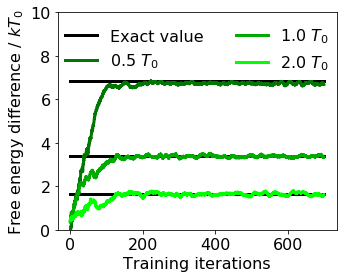

In [43]:
plt.figure(figsize=(5, 4))
dF_temp05_runningmean = dF_running_mean(dF_temp05, window=1000, step=10, dF_cut=10)
dF_temp10_runningmean = dF_running_mean(dF_temp10, window=1000, step=10, dF_cut=10)
dF_temp20_runningmean = dF_running_mean(dF_temp20, window=1000, step=10, dF_cut=10)
xrange = np.linspace(0, 700, len(dF_temp10_runningmean))

plt.plot([xrange[0], xrange[-1]], [dFs_ref[7], dFs_ref[7]], color='black', linewidth=3, label='Exact value')
plt.plot([xrange[0], xrange[-1]], [dFs_ref[10], dFs_ref[10]], color='black', linewidth=3)
plt.plot([xrange[0], xrange[-1]], [dFs_ref[14], dFs_ref[14]], color='black', linewidth=3)
plt.plot(xrange, dF_temp05_runningmean, linewidth=3, color='#007700', label='0.5 $T_0$')
plt.plot(xrange, dF_temp10_runningmean, linewidth=3, color='#00AA00', label='1.0 $T_0$')
plt.plot(xrange, dF_temp20_runningmean, linewidth=3, color='#00FF00', label='2.0 $T_0$')
plt.legend(loc='upper center', ncol=2, frameon=False)
plt.xlabel('Training iterations')
plt.ylabel('Free energy difference / $kT_0$')
plt.ylim(0, 10)
#plt.savefig(paper_dir + 'figs/double_well/free_energy_2BGs_conv.pdf', bbox_inches='tight', transparent=True)

In [55]:
dFs_direct = []
for t, T in enumerate(temperatures_analysis):
    dF_direct = (F2_by_temp-F1_by_temp)[t][20000:]# (Ex_by_temp2[t]/T - Jzx_by_temp2[t]) - (Ex_by_temp1[t]/T - Jzx_by_temp1[t])
    #dF_direct = (Ex_by_temp2[t] - Jzx_by_temp2[t]) - (Ex_by_temp1[t] - Jzx_by_temp1[t])
    #dF_direct /= T
    dFs_direct.append(dF_direct)
dFs_direct = np.array(dFs_direct)

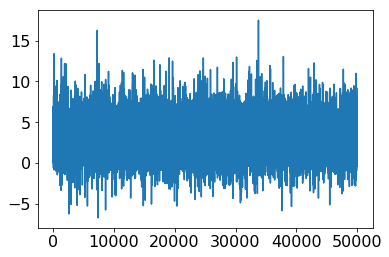

In [57]:
plt.plot(dFs_direct[10])

In [58]:
# bootstrap estimates
niter=100
N = dFs_direct.shape[1]
dFs_direct_bs = [dFs_direct[:, np.random.choice(N, size=N, replace=True)] for i in range(10)]
means = np.mean(dFs_direct, axis=1)
#uncertainties = np.std(np.mean(np.array(dFs_direct_bs), axis=2), axis=0)
uncertainties = np.std(dFs_direct, axis=1) / np.sqrt(niter)

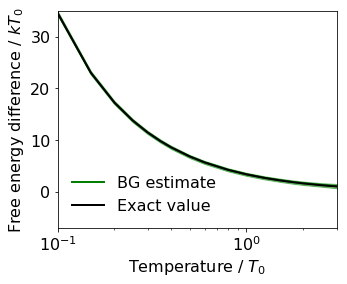

In [59]:
plt.figure(figsize=(5, 4))
#plt.errorbar(temperatures_analysis, means, 2.0*uncertainties,
#             color='green', linewidth=1, label='BG estimate')
plt.plot(temperatures_analysis, means, linewidth=2, color='green', label='BG estimate')
plt.plot(temperatures_analysis, dFs_ref, linewidth=2, color='black', label='Exact value')
plt.fill_between(temperatures_analysis, means-2.0*uncertainties, means+2.0*uncertainties, color='green', alpha=0.5)
plt.xlabel('Temperature / $T_0$')
plt.ylabel('Free energy difference / $kT_0$')
plt.semilogx()
plt.xlim(0.1, 3)
plt.ylim(-7, 35)

#plt.semilogy()
#plt.ylim(0, 1.0)
plt.legend(loc=3, frameon=False)
#plt.savefig(paper_dir + 'figs/double_well/free_energy_2BGs.pdf', bbox_inches='tight', transparent=True)